In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread, imshow
from skimage.transform import resize

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

In [2]:
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 1

NUM_TEST_IMAGES = 10

In [3]:
# get a list of files in each folder
base = r'/home/shaun/python/uni_work/ML_project/input'
img_list = os.listdir(os.path.join(base, 'rescaled_masks'))
mask_list = os.listdir(os.path.join(base, 'truth_gdal_jpg'))

# create a dataframe
df_images = pd.DataFrame(img_list, columns=['image_id'])

# filter out the non image file that's called .htaccess
df_images = df_images[df_images['image_id'] != '.htaccess']


# Example file name: SIMCEPImages_A13_C53_F1_s23_w2.TIF


# ======================================================
# Add a column showing how many cells are on each image
# ======================================================

# def get_num_cells(x):
#     # split on the _
#     a = x.split('_')
#     # choose the third item
#     b = a[2] # e.g. C53
#     # choose second item onwards and convert to int
#     num_cells = int(b[1:])
    
#     return num_cells

# create a new column called 'num_cells'
# df_images['num_cells'] = df_images['image_id'].apply(get_num_cells)


# ================================================
# Add a column indicating if an image has a mask.
# ================================================

# Keep in mind images and masks have the same file names.

def check_for_mask(x):
    if x in mask_list:
        return 'yes'
    else:
        return 'no'
    
# create a new column called 'has_mask'
df_images['has_mask'] = df_images['image_id'].apply(check_for_mask)

df_masks = df_images[df_images['has_mask'] == 'yes']

# create a new column called mask_id that is just a copy of image_id
df_masks['mask_id'] = df_masks['image_id']

df_masks.shape


# ===========================================================
# Add a column showing how much blur was added to each image
# ===========================================================

# def get_blur_amt(x):
#     # split on the _
#     a = x.split('_')
#     # choose the third item
#     b = a[3] # e.g. F1
#     # choose second item onwards and convert to int
#     blur_amt = int(b[1:])
    
#     return blur_amt

# create a new column called 'blur_amt'
# df_images['blur_amt'] = df_images['image_id'].apply(get_blur_amt)
df_images.head(10)

,image_id,has_mask
0,rolleston_21504_512.jpeg,yes
1,rolleston_15360_20992.jpeg,yes
2,rolleston_16384_10240.jpeg,yes
3,rolleston_14848_23552.jpeg,yes
4,rolleston_20480_14848.jpeg,yes
5,rolleston_6144_23040.jpeg,yes
6,rolleston_8704_7680.jpeg,yes
7,rolleston_5120_14848.jpeg,yes
8,rolleston_19456_17408.jpeg,yes
9,rolleston_5632_4096.jpeg,yes


In [4]:
# create a test set
df_test = df_masks.sample(NUM_TEST_IMAGES, random_state=101)

# Reset the index.
# This is so that we can use loc to access mask id's later.
df_test = df_test.reset_index(drop=True)

# create a list of test images
test_images_list = list(df_test['image_id'])


# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_masks = df_masks[~df_masks['image_id'].isin(test_images_list)]

print(df_masks.shape)
print(df_test.shape)

(2240, 3)
(10, 3)


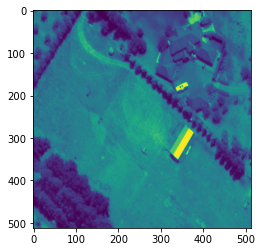

In [5]:
sample_image = 'rolleston_0_6144.jpeg'
path_image = os.path.join(base, 'truth_gdal_jpg', sample_image) 

# read the image using skimage
image = imread(path_image)

plt.imshow(image)

In [6]:
print('Shape: ', image.shape)
print('Max pixel value: ', image.max())
print('Min pixel value: ', image.min())

Shape:  (512, 512)
Max pixel value:  255
Min pixel value:  0


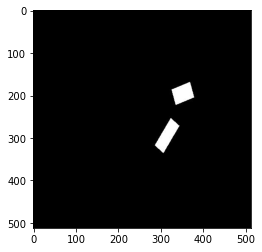

In [7]:
sample_mask = 'rolleston_0_6144.jpeg'
path_mask = os.path.join(base, 'rescaled_masks', sample_mask)

# read the mask using skimage
mask = imread(path_mask)

plt.imshow(mask, cmap='gray')

In [8]:
print('Shape: ', mask.shape)
print('Max pixel value: ', mask.max())
print('Min pixel value: ', mask.min())

Shape:  (512, 512)
Max pixel value:  255
Min pixel value:  0


In [9]:
# Get lists of images and their masks.
image_id_list = list(df_masks['image_id'])
mask_id_list = list(df_masks['mask_id'])
test_id_list = list(df_test['image_id'])

# Create empty arrays

X_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

Y_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

X_test = np.zeros((NUM_TEST_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

In [10]:
# X_train

for i, image_id in enumerate(image_id_list):
    
    path_image = os.path.join(base, 'truth_gdal_jpg', image_id)
    
    # read the image using skimage
    image = imread(path_image)
    
    # # resize the image
    # image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    image = np.expand_dims(image, axis=-1)
    
    # insert the image into X_train
    X_train[i] = image
    
X_train.shape

(2240, 512, 512, 1)

In [11]:
# Y_train

for i, mask_id in enumerate(mask_id_list):
    
    path_mask = os.path.join(base, 'rescaled_masks', mask_id) 
    
    # read the image using skimage
    mask = imread(path_mask)
    
    # # resize the image
    # mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    mask = np.expand_dims(mask, axis=-1)
    
    # insert the image into Y_Train
    Y_train[i] = mask

Y_train.shape

(2240, 512, 512, 1)

In [12]:
# X_test
selected = ['rolleston_0_6144.jpeg', 'rolleston_0_6656.jpeg', 'rolleston_0_3584.jpeg',
            'rolleston_0_7168.jpeg', 'rolleston_0_11264.jpeg', 'rolleston_0_12800.jpeg',
            'rolleston_0_13312.jpeg', 'rolleston_0_20480.jpeg', 'rolleston_0_20992.jpeg',
            'rolleston_0_22016.jpeg']

dense_blds = ['rolleston_13824_13312.jpeg', 'rolleston_13824_13824.jpeg', 'rolleston_14336_10752.jpeg',
              'rolleston_14336_11264.jpeg', 'rolleston_14336_11776.jpeg', 'rolleston_14336_25088.jpeg',
              'rolleston_14848_10240.jpeg', 'rolleston_14848_11264.jpeg', 'rolleston_15360_1536.jpeg',
              'rolleston_15360_6656.jpeg']

for i, image_id in enumerate(dense_blds):
    
    path_image = os.path.join(base, 'truth_gdal_jpg', image_id)
    
    # read the image using skimage
    image = imread(path_image)
    
    # resize the image
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    image = np.expand_dims(image, axis=-1)
    
    # insert the image into X_test
    X_test[i] = image
    
X_test.shape

(10, 512, 512, 1)

In [31]:
test_masks = np.zeros((NUM_TEST_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

for i, img in enumerate(dense_blds):
    path_image = '/home/shaun/python/uni_work/ML_project/input/rescaled_masks/' + img
    image = imread(path_image)
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    image = np.expand_dims(image, axis=-1)
    test_masks[i] = image
test_masks.shape

(10, 512, 512, 1)

In [13]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

2021-10-28 12:00:23.196237: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-28 12:00:23.196296: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [14]:
# source: https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277


inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy')

model.summary()

2021-10-28 12:00:30.021081: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-10-28 12:00:30.021109: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (slowis-PC): /proc/driver/nvidia/version does not exist
2021-10-28 12:00:30.021339: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512, 512, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 160         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 512, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [16]:
filepath = "model.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

callbacks_list = [earlystopper, checkpoint]

history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=30, 
                    callbacks=callbacks_list)

NameError: name 'model' is not defined

In [15]:
real_test = np.zeros((NUM_TEST_IMAGES, IMG_HEIGHT, IMG_WIDTH, 4, IMG_CHANNELS), dtype=np.uint8)
real_path = r'/home/shaun/python/uni_work/ML_project/input/real_ones'

for i, image_id in enumerate(os.listdir(real_path)):
    
    path_image = os.path.join(real_path, image_id)
    
    # read the image using skimage
    image = imread(path_image)
    
    # resize the image
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    image = np.expand_dims(image, axis=-1)
    
    # insert the image into X_test
    real_test[i] = image
    
real_test.shape

(10, 512, 512, 4, 1)

In [16]:
# Make a prediction

# use the best epoch
model.load_weights('model.h5')

test_preds = model.predict(X_test)

2021-10-28 12:00:36.409947: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [17]:
# Threshold the predictions

preds_test_thresh = (test_preds >= 0.31).astype(np.uint8)

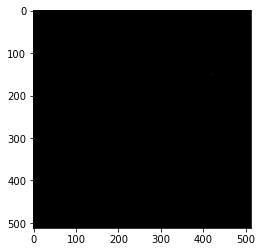

In [18]:
test_img = preds_test_thresh[5, :, :, 0]

plt.imshow(test_img, cmap='gray')

In [19]:
test_preds.shape

(10, 512, 512, 1)

In [20]:
df_test.loc[1,'image_id']

'rolleston_16384_17408.jpeg'

In [21]:
df_test.loc[2,'image_id']

'rolleston_17920_20480.jpeg'

In [22]:
import keras

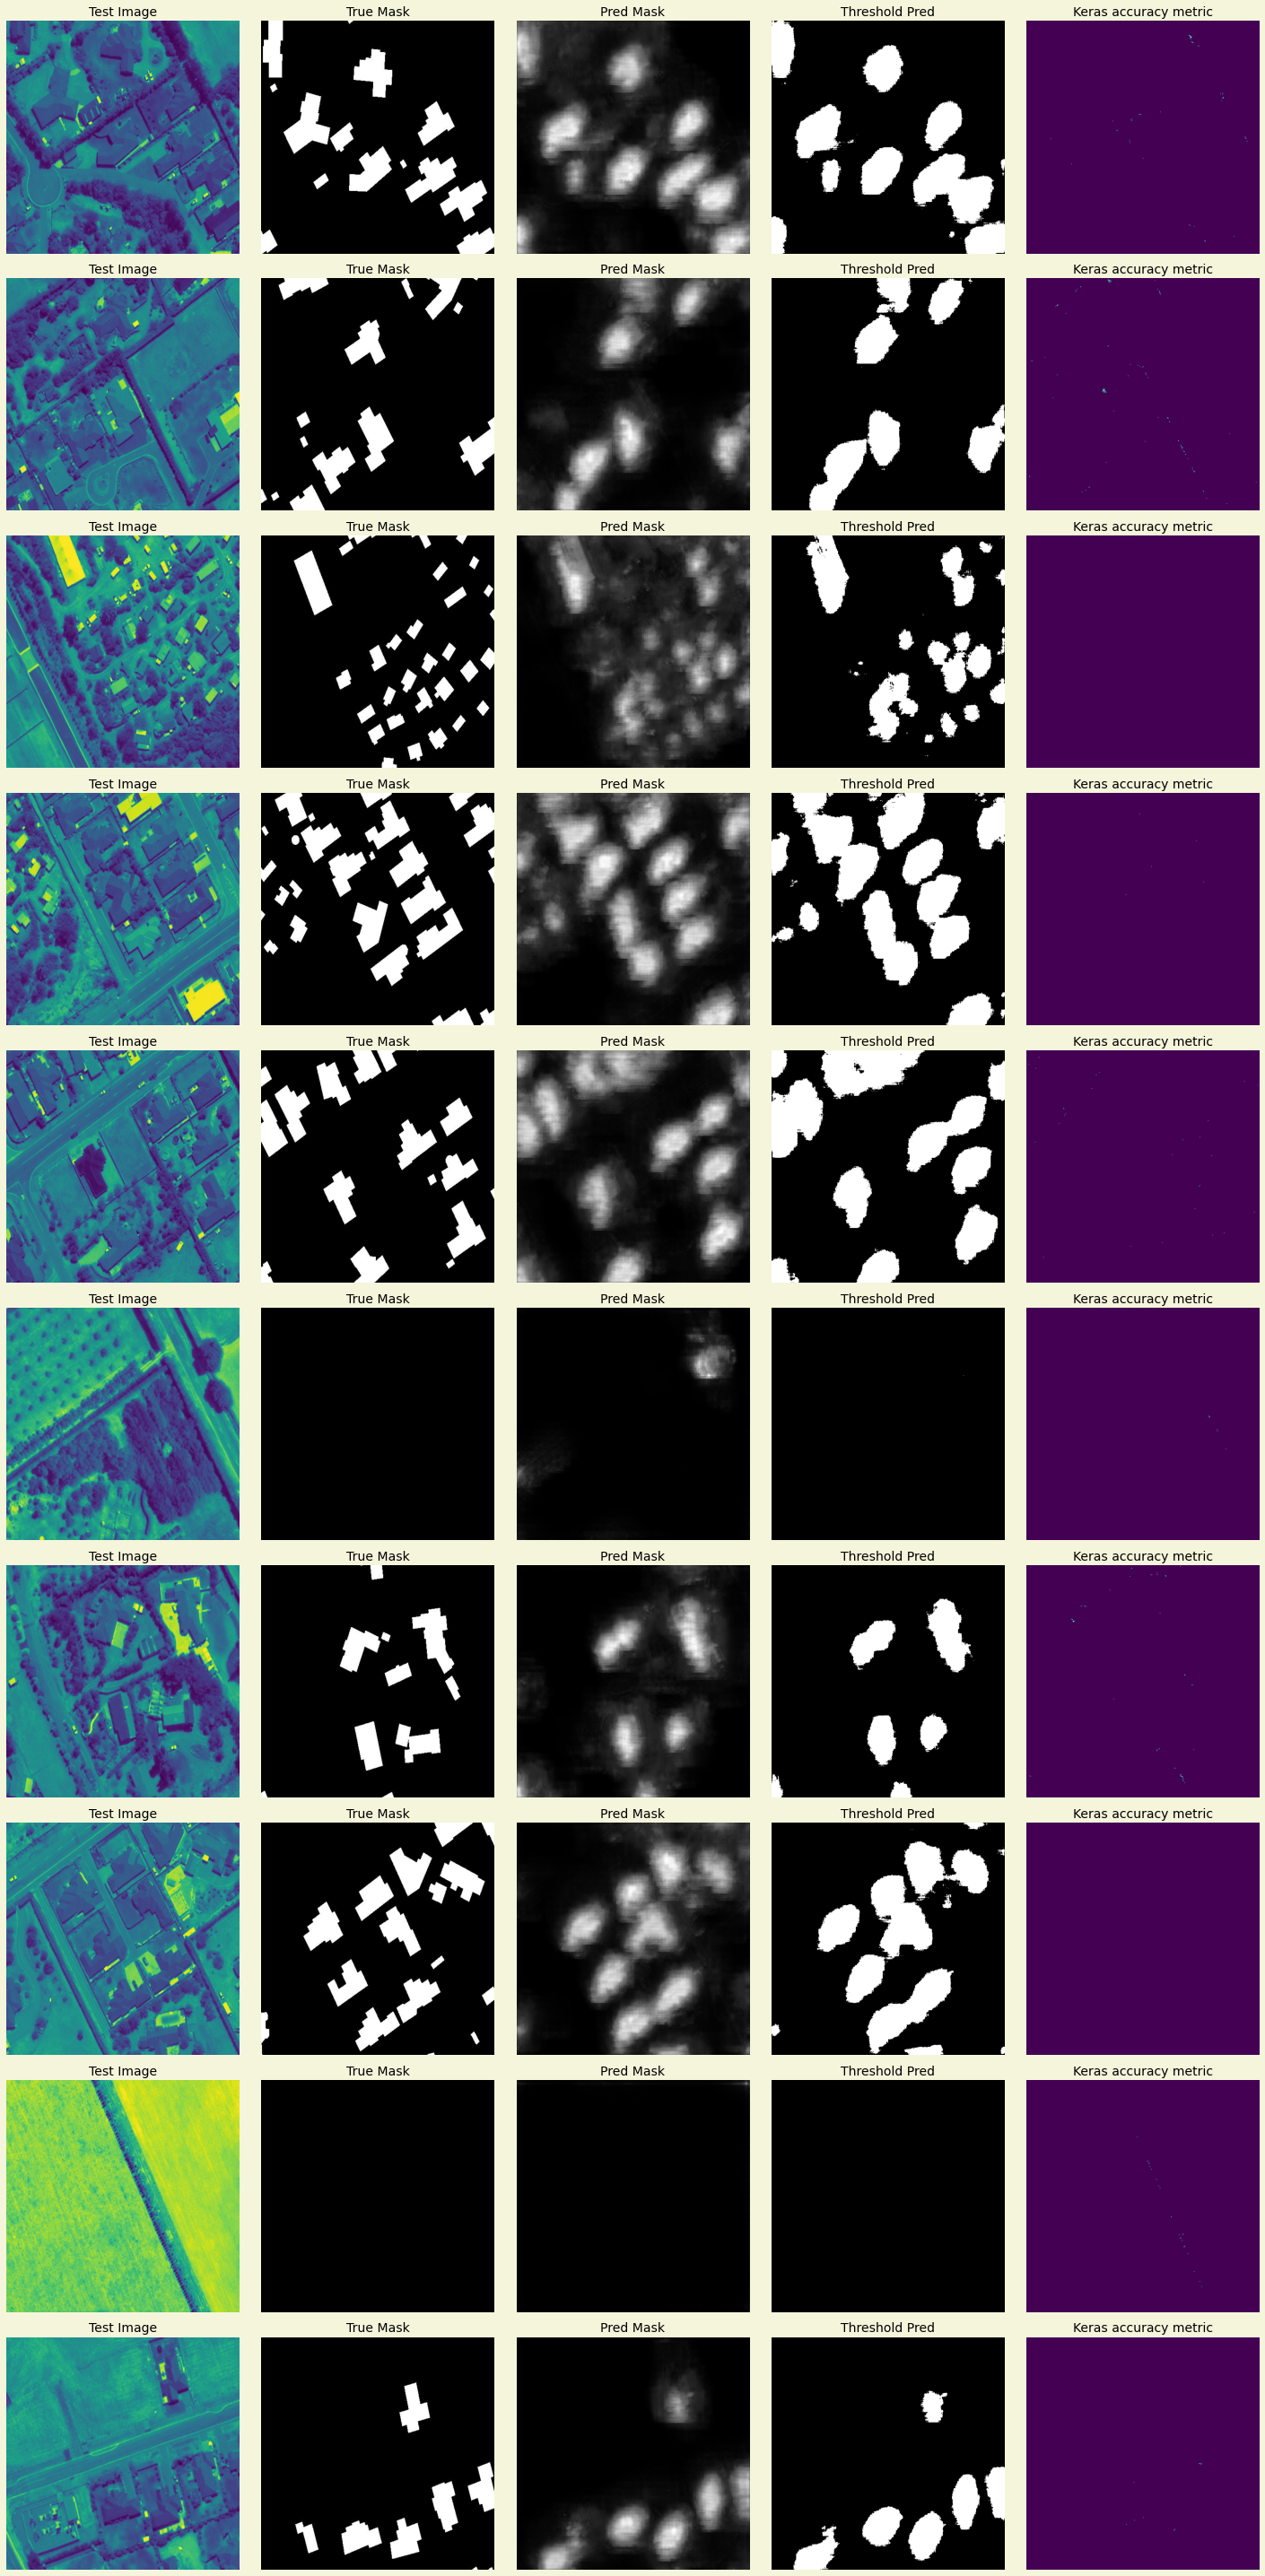

In [23]:
def plot_subplots(num_rows):
    count = 1
    accuracy = keras.metrics.binary_accuracy(X_test, test_preds, threshold=0.01)
    for i in range(0, num_rows):
        # image
        plt.subplot(num_rows,5,count)
        test_image = X_test[i, :, :, 0]
        plt.imshow(test_image)
        plt.title('Test Image', fontsize=14)
        plt.axis('off')
        count += 1

        # true mask
        plt.subplot(num_rows,5,count)
        mask_id = dense_blds[i]
        path_mask = '/home/shaun/python/uni_work/ML_project/input/rescaled_masks/' + mask_id
        mask = imread(path_mask)
        mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        plt.imshow(mask, cmap='gray')
        plt.title('True Mask', fontsize=14)
        plt.axis('off')
        count += 1

        # predicted mask
        plt.subplot(num_rows,5,count)
        test_mask = test_preds[i, :, :, 0]
        plt.imshow(test_mask, cmap='gray')
        plt.title('Pred Mask', fontsize=14)
        plt.axis('off')
        count += 1

        # threshold predicted mask
        plt.subplot(num_rows,5,count)
        test_mask = preds_test_thresh[i, :, :, 0]
        plt.imshow(test_mask, cmap='gray')
        plt.title('Threshold Pred', fontsize=14)
        plt.axis('off')
        count += 1
        
        # Keras accuracy metric
        plt.subplot(num_rows,5,count)
        plt.imshow(accuracy[i, :, :])
        plt.title('Keras accuracy metric', fontsize=14)
        plt.axis('off')
        count += 1
        

# set up the canvas for the subplots
fig = plt.figure(figsize=(20,40))
plt.axis('Off')
fig.patch.set_facecolor('beige')

plot_subplots(10)

plt.tight_layout()
# plt.show()
plt.savefig('Comparisons.jpeg')

In [23]:
# Use own data to verify accuracy, i.e. pixel predicted between test and training.
# Categorise test vs train and explain why model trained in the way that it did.
# Use road train img to talk about
# Apply to Rolleston over a few years, and why particular images were chosen
# Compare urban and rural accuracy with masks
# For accuracy, compare predicted and mask

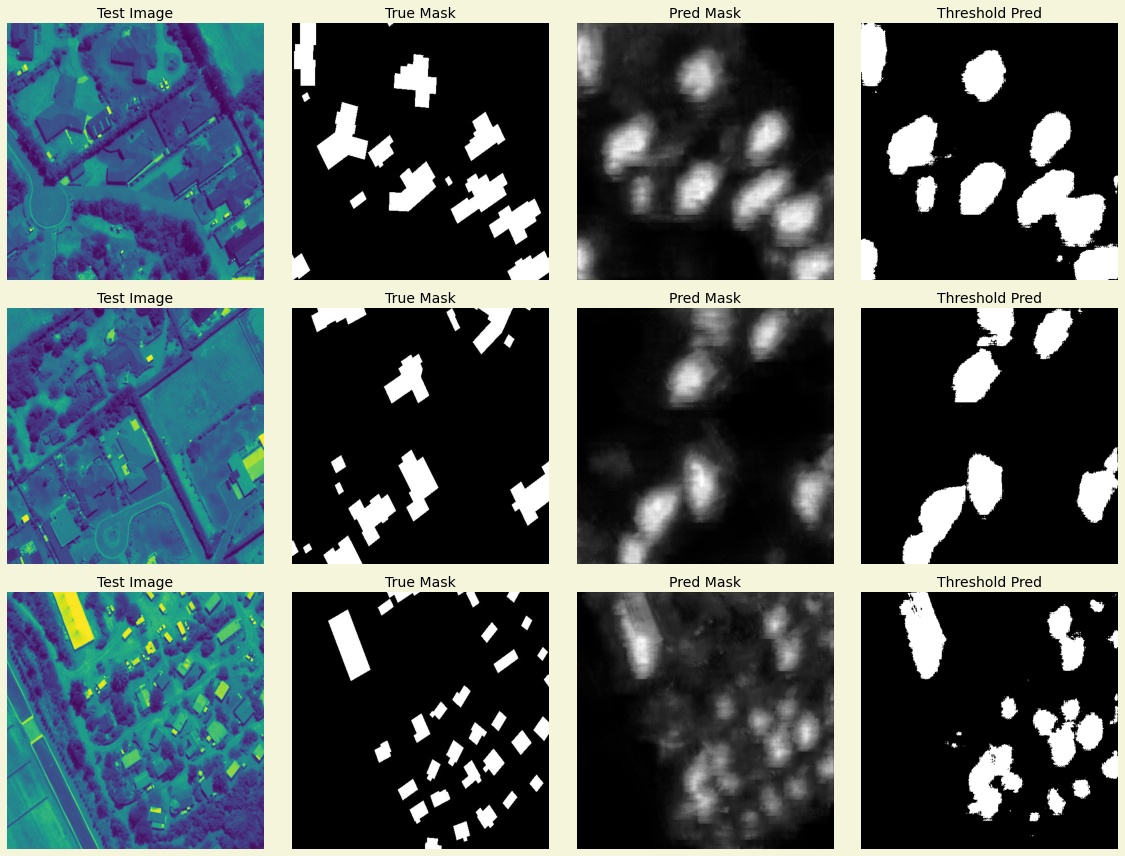

In [24]:
def plot_subplots(num_rows):
    count = 1
    for i in range(0, num_rows):
        # image
        plt.subplot(num_rows,4,count)
        test_image = X_test[i, :, :, 0]
        plt.imshow(test_image)
        plt.title('Test Image', fontsize=14)
        plt.axis('off')
        count += 1

        # true mask
        plt.subplot(num_rows,4,count)
        mask_id = dense_blds[i]
        path_mask = '/home/shaun/python/uni_work/ML_project/input/rescaled_masks/' + mask_id
        mask = imread(path_mask)
        mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        plt.imshow(mask, cmap='gray')
        plt.title('True Mask', fontsize=14)
        plt.axis('off')
        count += 1

        # predicted mask
        plt.subplot(num_rows,4,count)
        test_mask = test_preds[i, :, :, 0]
        plt.imshow(test_mask, cmap='gray')
        plt.title('Pred Mask', fontsize=14)
        plt.axis('off')
        count += 1

        # threshold predicted mask
        plt.subplot(num_rows,4,count)
        test_mask = preds_test_thresh[i, :, :, 0]
        plt.imshow(test_mask, cmap='gray')
        plt.title('Threshold Pred', fontsize=14)
        plt.axis('off')
        count += 1

# set up the canvas for the subplots
fig = plt.figure(figsize=(16,12))
plt.axis('Off')
fig.patch.set_facecolor('beige')

plot_subplots(3)

plt.tight_layout()
# plt.show()
plt.savefig('predictions.jpeg')

In [25]:
from sklearn.metrics import confusion_matrix
import keras

In [54]:
X_test[0, :, :, 0].shape

(512, 512)

In [67]:
accuracy = keras.metrics.binary_accuracy(X_test, test_preds, threshold=0.01)

(-0.5, 511.5, 511.5, -0.5)

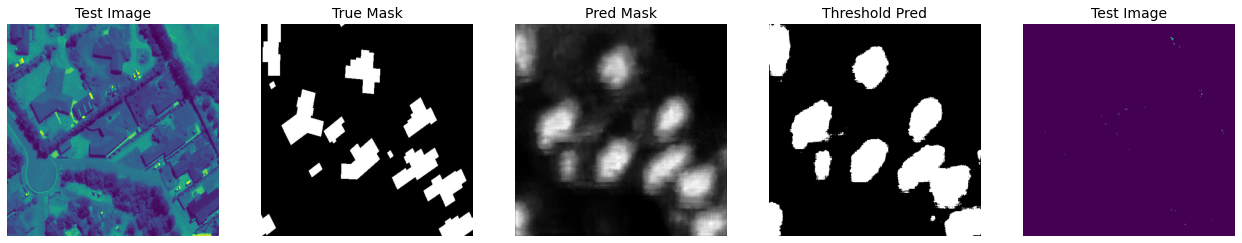

In [68]:
fig, ax = plt.subplots(1, 5, figsize=(22,10))

test_image = X_test[0, :, :, 0]
ax[0].imshow(test_image)
ax[0].set_title('Test Image', fontsize=14)
ax[0].axis('off')

# true mask
mask_id = dense_blds[0]
path_mask = '/home/shaun/python/uni_work/ML_project/input/rescaled_masks/' + mask_id
mask = imread(path_mask)
mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
ax[1].imshow(mask, cmap='gray')
ax[1].set_title('True Mask', fontsize=14)
ax[1].axis('off')

# predicted mask
test_mask = test_preds[0, :, :, 0]
ax[2].imshow(test_mask, cmap='gray')
ax[2].set_title('Pred Mask', fontsize=14)
ax[2].axis('off')

# threshold predicted mask
test_mask = preds_test_thresh[0, :, :, 0]
ax[3].imshow(test_mask, cmap='gray')
ax[3].set_title('Threshold Pred', fontsize=14)
ax[3].axis('off')

ax[4].imshow(accuracy[0, :, :])
ax[4].set_title('Test Image', fontsize=14)
plt.axis('off')

In [24]:
from sklearn.metrics import confusion_matrix as cm
import sklearn

In [32]:
binary_test = np.where(test_masks > 0, 1, 0).ravel()
binary_preds = np.where(test_preds > 0.31, 1, 0).ravel()

In [33]:
binary_preds.shape

(2621440,)

In [34]:
binary_test.shape

(2621440,)

In [35]:
confusion_matrix = cm(binary_test, binary_preds, normalize='all')

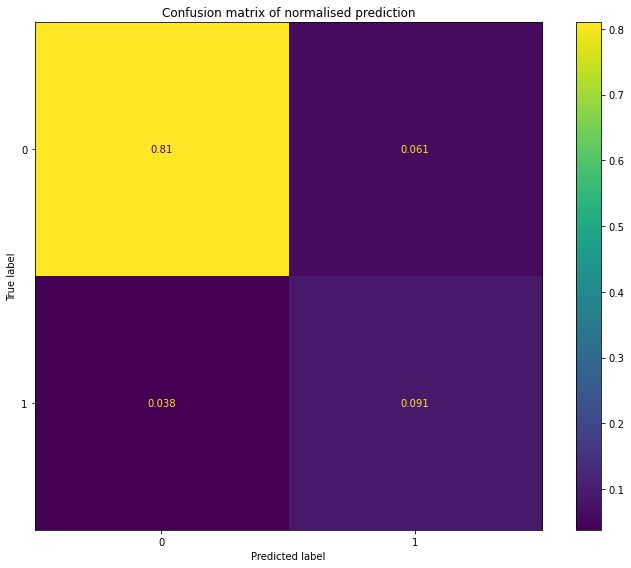

In [36]:
display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=None)

fig, ax = plt.subplots(figsize=(10, 8))
data = display.plot(ax=ax)
plt.title('Confusion matrix of normalised prediction')
plt.tight_layout()
plt.savefig('confusion.jpeg', dpi=200)

In [113]:
binary_test

array([1, 1, 1, ..., 1, 1, 1])

In [44]:
preds = np.argmax(test_preds, axis=)
preds

2578264

In [36]:
test_preds

array([[[[0.23970416],
         [0.26075965],
         [0.32238665],
         ...,
         [0.01672128],
         [0.02138722],
         [0.05815831]],

        [[0.28570879],
         [0.31152695],
         [0.3492123 ],
         ...,
         [0.00366119],
         [0.00677204],
         [0.01710477]],

        [[0.28678128],
         [0.3150838 ],
         [0.37038702],
         ...,
         [0.00277248],
         [0.00351843],
         [0.01411557]],

        ...,

        [[0.48514774],
         [0.53239685],
         [0.5637452 ],
         ...,
         [0.3379749 ],
         [0.2977537 ],
         [0.28809923]],

        [[0.4465578 ],
         [0.487752  ],
         [0.5237287 ],
         ...,
         [0.27256036],
         [0.24667251],
         [0.22924823]],

        [[0.45396215],
         [0.4760051 ],
         [0.4925595 ],
         ...,
         [0.2559843 ],
         [0.24592143],
         [0.23379803]]],


       [[[0.04089051],
         [0.01734328],
         [0.01